# Tarea 1: Multi-armed bandits
## IELE 4922: Reinforcement Learning
## Wilmar Calderón
## 201630701


### 0. Inicialización de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Inicializaicón de los parámetros de los modelos
    #Número de los bandits (Acciones)
n_bandits=15
    #Media de las acciones q*
mean_q=10
    #Varianza de las acciones q*
variance_q=4
    #Varianza de cada acción (recompensa)
action_var=2
    #Número de pasos: horizonte
steps=5000
    #número de iteraciones (repeticiones del experimento)
iter=1000

### 1. Acerca de los multi-armed bandits

In [3]:
# Función para generar una visualización de q*(a_k)
#num_actions por definición será igual al número de bandits (entrada por parámetro para permitir la escalabilidad de la función)
def generate_q(mean, variance, num_actions, steps,step_variance):
    q_ast=np.zeros((steps,num_actions))
    q_ini=np.random.normal(mean, np.sqrt(variance), num_actions)
    for i,mean_q in enumerate(q_ini):
        q_ast[:,i]=np.random.normal(mean_q, np.sqrt(step_variance), steps)
    return q_ast

q_val=generate_q(mean_q,variance_q,n_bandits,steps,action_var)

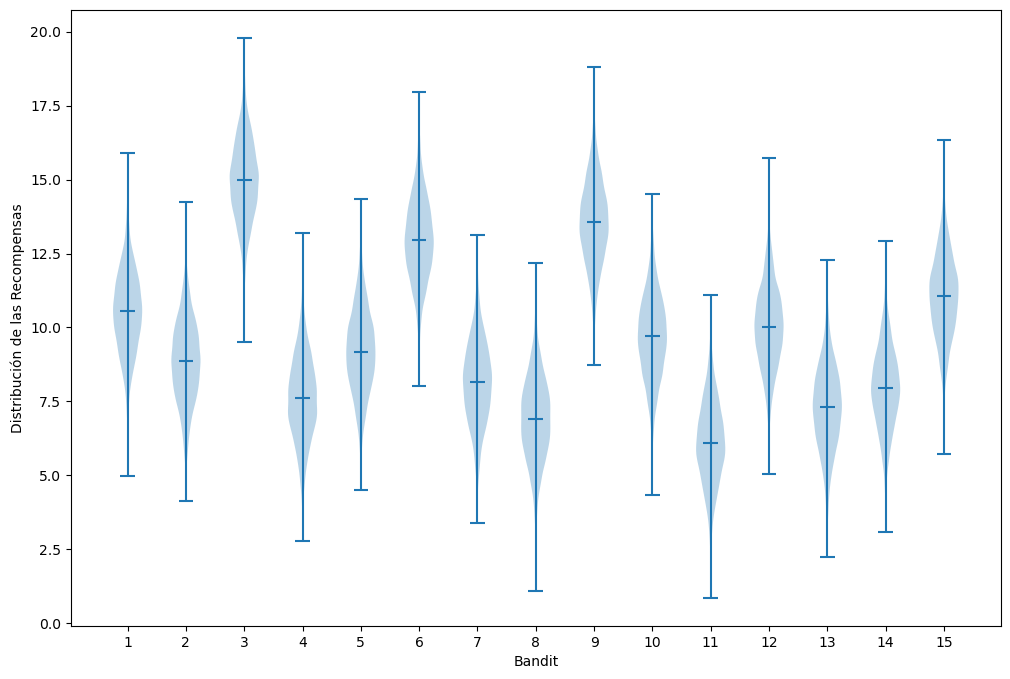

In [4]:
#Figura para obervar contextualmente la distribución de las recompensas de los n-bandits del problema
plt.figure(figsize=(12,8))
plt.ylabel('Distribución de las Recompensas')
plt.xlabel('Bandit')
plt.xticks(range(1,n_bandits+1))
plt.violinplot(q_val, positions=range(1,n_bandits+1), showmedians=True)
plt.show()

### 1.A $\varepsilon$-greedy

In [5]:
# Función que obtiene el índice del máximo valor dentro de un arreglo (útil para calcular ese bandit que maximiza la recompensa)
# input: valores de las recompensas (arreglo)
# output: índice de la posición que corresponde al valor máximo dentro del arreglo
def arg_max(q_ast):
    arg_max_i=np.argmax(q_ast)
        #Revisión si hay 2 o más máximos iguales: devuelve el primer índice del valor máximo de la función
    if isinstance(arg_max_i, list):
        return arg_max_i[0]
    else:
        return arg_max_i

# Función para obtener las recompensas de las acciones a tomar. Considera un número aleatorio que sigue una distribución normal centrada en q* y con varianza definida (parámetro)
# input: un arreglo con las estimaciones iniciales de las recompensas
# output: un arreglo con valores de una distribución normal centrada en en q_ast (parámetro) y var_action (parámetro)
def f_rewards(q_ast,var_action):
    return np.random.normal(q_ast,np.sqrt(var_action))




Para el caso de la implementación del algoritmo $\varepsilon$ -_greedy_ se seguirá el pseudocódigo planteado por (Sutton & Barto, 2018) en el capítulo 2 con algunos comentarios (en _cursiva_):

-_inicializar los bandits_:


### *Initialize, for a=1 to k:*
$Q(a) \leftarrow 0$
$N(a) \leftarrow 0$


-_Hacer el loop para la cantidad de steps para hacer la explotación (primer caso) o la exploración (segundo caso)_



### *Loop forever:*

$A \leftarrow argmax_a Q(a)$ with probability $1-\epsilon$

$A \leftarrow random action$ with probability $\epsilon$ 

_Recomensa_
$R \leftarrow bandit(A)$

$N(A) \leftarrow N(A)+1$

$Q(A) \leftarrow Q(A) + \frac{1}{N(A)}(R-Q(A))$

En este caso, la función $Q(A)$ determina el aprendizaje como un proceso de aprendizaje incremental. A continuación la implementación del algoritmo $\epsilon$-greedy:


In [6]:
# Definición de función para entrenar a los bandits de acuerdo con la política epsilon-greedy
# input: epsilon (float), num_bandits (int), steps -u horizonte-(int), iter (int)
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima
def epsilon_greedy (epsilon,num_bandits,steps,iter,action_var_i):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
            #arreglo para almacenar los valores de la recompensa esperada de cada acción tomada
        q_a=np.zeros(n_bandits)
            #arreglo que contabiliza el número de iteraciones evalaudas hasta el momento de evaluación
        n=np.zeros(n_bandits)
            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)

            #inicialización de valores q* para la iteración de evaluación        
        q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #inicialziación del valor teórico máximo
        max_ini=arg_max(q_ini)

            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):

            act=0 #representa el bandit que se activa en la acción
            if np.random.rand()<epsilon:
                act=int(np.random.randint(num_bandits)) #Explotación
            else:
                act=int(arg_max(q_a)) #Exploración

                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var_i)
            
                #actualiza el número de evaluación de la iteración
            n[act]+=1
                #implementación incremental: permite el aprendizaje de acuerdo con el error (R-Q) y la tasa 1/N 
            q_a[act]+=(reward_i-q_a[act])/n[act]

                #almacenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i
            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2



In [7]:
#Función para evaluar múltiples valores para epsilon en la implementación de epsilon-greedy
def eval_eps(epsilons,action_var_i):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r=np.zeros((steps,len(epsilons)))
    optimal_res=np.zeros((steps,len(epsilons)))
        #evalaución de las combinacioens de número de iteraciones y valor de epsilon para la evaluación
    for e in range(len(epsilons)):
        rewards,percent=epsilon_greedy(epsilons[e],n_bandits,steps,iter,action_var_i)
        avg_r[:,e]=rewards
        optimal_res[:,e]=percent   
    return avg_r,optimal_res

#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0,0.01,0.1]

steps_arr=np.arange(0,steps,dtype=int)
avg_r0,optimal_r0=eval_eps(epsilons,action_var)

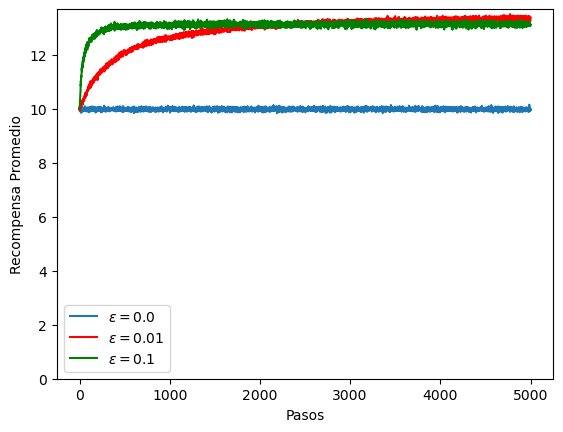

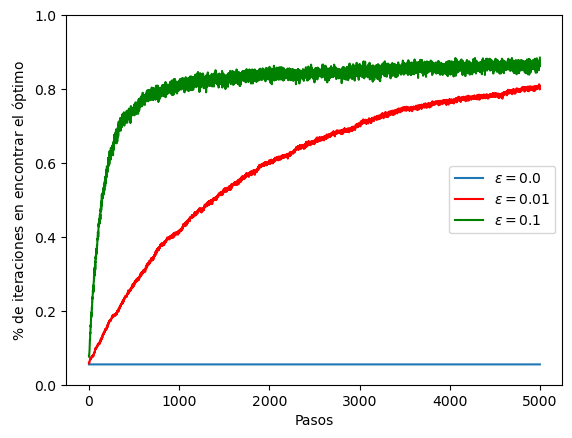

In [19]:
#gráfica para la recompensa
plt.figure()
plt.plot(avg_r0[:,0],label=f"$\epsilon=$"+str(epsilons[0]))
plt.plot(avg_r0[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1]))
plt.plot(avg_r0[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2]))
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r0[:,0],label=f"$\epsilon=$"+str(epsilons[0]))
plt.plot(optimal_r0[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1]))
plt.plot(optimal_r0[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2]))
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0,1)
plt.legend()
plt.show()


A partir de las gráficas obtenidas, se puede establecer que el parámetro óptimo para $\epsilon$ es 0.1, valor que garantiza que se haga una constante exploración y posterior explotación. Adicionalmente, se observa ue a una mayor tasa de exploración, el porcentaje en llegar al óptimo se puede obtener a un menor número de pasos (visto con la gráfica verde que tiene valores más altos desde pasos más bajos)

Con respecto al caso cuando $\epsilon=0$ en este caso, no hay exploración alguna. En este punto es importante notar también que, según el pseudo código de Sutton & Barto (2018) la inicialización de $Q(A)$ se da en 0, motivo por el cual posiblemente el arranque de la "explotación" nunca es efectivo por que ningún bandit va a tener una media cercana a 0.  Para evaluar si la modificaicón del $Q(A)$ inciial afecta el resultado, a continuación se modificará el código para establecer que los valores de $Q(A)$ se inicialicen en las medias de los bandits, para evaluar si la predicción mejora con el establecimiento de un valor inicial.

In [23]:
# Definición de función para entrenar a los bandits de acuerdo con la política epsilon-greedy
# input: epsilon (float), num_bandits (int), steps -u horizonte-(int), iter (int)
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima
def epsilon_greedy1 (epsilon,num_bandits,steps,iter,action_var_i):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
            #arreglo para almacenar los valores de la recompensa esperada de cada acción tomada
        q_a=np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #arreglo que contabiliza el número de iteraciones evalaudas hasta el momento de evaluación
        n=np.zeros(n_bandits)
            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)

            #inicialización de valores q* para la iteración de evaluación        
        q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #inicialziación del valor teórico máximo
        max_ini=arg_max(q_ini)

            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):

            act=0 #representa el bandit que se activa en la acción
            if np.random.rand()<epsilon:
                act=int(np.random.randint(num_bandits)) #Explotación
            else:
                act=int(arg_max(q_a)) #Exploración

                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var_i)
            
                #actualiza el número de evaluación de la iteración
            n[act]+=1
                #implementación incremental: permite el aprendizaje de acuerdo con el error (R-Q) y la tasa 1/N 
            q_a[act]+=(reward_i-q_a[act])/n[act]

                #almacenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i
            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2

#Función para evaluar múltiples valores para epsilon en la implementación de epsilon-greedy
def eval_eps1(epsilons,action_var_i):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r=np.zeros((steps,len(epsilons)))
    optimal_res=np.zeros((steps,len(epsilons)))
        #evalaución de las combinacioens de número de iteraciones y valor de epsilon para la evaluación
    for e in range(len(epsilons)):
        rewards,percent=epsilon_greedy1(epsilons[e],n_bandits,steps,iter,action_var_i)
        avg_r[:,e]=rewards
        optimal_res[:,e]=percent   
    return avg_r,optimal_res

#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0,0.01,0.1]


avg_r01,optimal_r01=eval_eps1(epsilons,action_var)



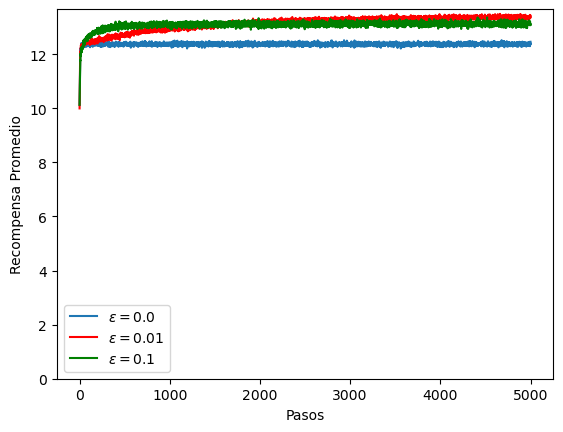

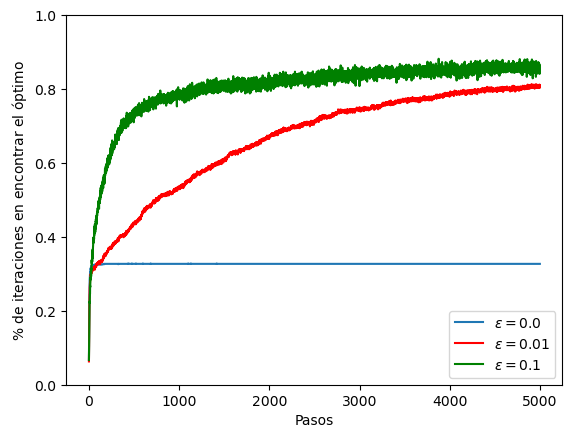

In [24]:
#gráfica para la recompensa
plt.figure()
plt.plot(avg_r01[:,0],label=f"$\epsilon=$"+str(epsilons[0]))
plt.plot(avg_r01[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1]))
plt.plot(avg_r01[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2]))
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r01[:,0],label=f"$\epsilon=$"+str(epsilons[0]))
plt.plot(optimal_r01[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1]))
plt.plot(optimal_r01[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2]))
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0,1)
plt.legend()
plt.show()

Con respecto a las modificaciones del código, se evidencia que el principal cambio se da con $\epsilon=0$, pudiendo obtener un valor del óptimo. Sin embargo, este valor no es superior al 40%, por lo que no tendría una capacidad predictiva buena en ningún escenario, incluso en aquellos con alto número de pasos.

### 1.B Gradient Bandit

La implementación de Gradient Bandit busca que el aprendizaje del modelo esté guiado por una preferencia numérica a cada acción $a$, de tal forma, que se empiecen a seleccionar esas acciones $a$ (o equivalentemente el bandit k) que maximice la preferencia (en relación con la preferencia de las demás acciones). Para este caso se puede definir:

### La preferencia
$H_t(a)$

### La probabilidad de seleccionar una acción
(que va asociado a la probabilidad de tomar la acción $a$ en el tiempo $t)

$Pr(A_t=a) \doteq \pi_t(a) \doteq \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}$

de tal forma que el aprendizaje de este algoritmo está orientado por las siguientes ecuaciones:

$H_{t+1}(A_t) \doteq H_t(A_t)+\alpha (R_t-\bar{R_t})(1-\pi_t(A_t))$,

$H_{t+1}(a) \doteq H_t(a)-\alpha (R_t-\bar{R_t})(1-\pi_t(a))$ para las acciones $a \neq A_t$

en donde $\alpha$ es el tamaño del paso, $\bar{R_t}$ es la suma de recomensas hasta el tiempo $t$, que sirve como línea base de las recompensas.

De acuerdo a esto, el aprendizaje se realiza basado en las preferencias de cada acción. A continuación se muestra la implementación del algoritmo de Gradient Bandit

In [9]:
# Función para entrenar a los bandits de acuerdo con la política gradient bandit
# input: alpha (float), num_bandits (int), steps -u horizonte-(int), iter (int)
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima de acuerdo con
# la metodología de gradient bandit.

def gradient_bandit (alpha,num_bandits,steps,iter,action_var_i):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
        
            #(Sutton & Barto): Initially all action preferences are the same (e.g., H1(a) = 0, for all a) so that all actions have an equal probability of being selected.
        preferences = np.zeros(n_bandits)
        pi_a= np.ones(n_bandits)/n_bandits

            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)

            #inicialización de valores q* para la iteración de evaluación        
        q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #inicialziación del valor teórico máximo
        max_ini=arg_max(q_ini)

            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):
                #selección de una acción del bandit: selección con una probabilidad guiada por las \pi (tiende a seleccionar aquel con mayor probabilida de preferencia)
            act=np.random.choice(np.arange(n_bandits),p=pi_a)
                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var_i)
            
                #(Sutton & Barto) and ¯Rt 2 R is the average of all the rewards up through and including time t, which can be computed incrementally
            baseline=rewards[:s].mean() if s>0 else 0

                #Cálculo de las preferencias de cada una de las acciones
            for k in range(num_bandits):
                if k == act:
                    preferences[k]+=alpha*(reward_i-baseline)*(1-pi_a[k])
                else:
                    preferences[k]-=alpha*(reward_i-baseline)*pi_a[k]
            
            e_x=np.exp(preferences)
            pi_a=e_x/e_x.sum()

                #alamcenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i

            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2

In [10]:


#Función para evaluar múltiples valores para alpha en la uimplementación de epsilon-greedy
def eval_alp(alphas,action_var_i):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r=np.zeros((steps,len(alphas)))
    optimal_res=np.zeros((steps,len(alphas)))
        #evalaución de las combinacioens de número de iteraciones y valor de alpha para la evaluación
    for a in range(len(alphas)):
        rewards,percent=gradient_bandit(alphas[a],n_bandits,steps,iter,action_var_i)
        avg_r[:,a]=rewards
        optimal_res[:,a]=percent   
    return avg_r,optimal_res

#definición de la lista de epsilon que se quiere evaluar
alphas=[0.1,0.4]
steps_arr=np.arange(0,steps,dtype=int)
avg_r1,optimal_r1=eval_alp(alphas,action_var)

0.1


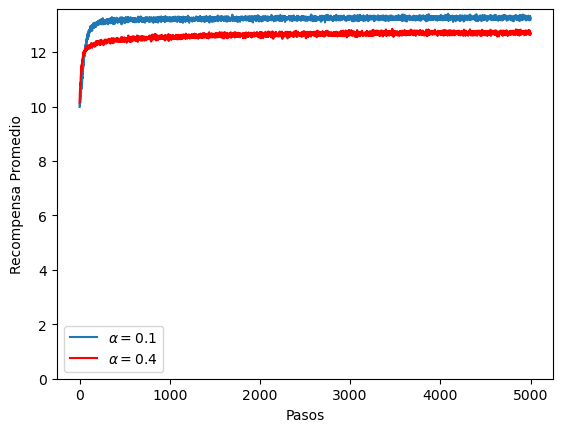

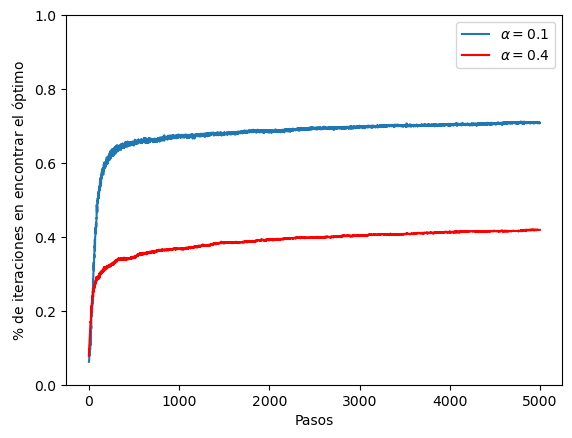

In [43]:
#gráfica para la recompensa
print(alphas[0])

plt.figure()
plt.plot(avg_r1[:,0],label=r"$\alpha=$"+str(alphas[0]))
plt.plot(avg_r1[:,1],c="r",label=r"$\alpha=$"+str(alphas[1]))

plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r1[:,0],label=r"$\alpha=$"+str(alphas[0]))
plt.plot(optimal_r1[:,1],c="r",label=r"$\alpha=$"+str(alphas[1]))

plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0,1)
plt.legend()
plt.show()

Basado en los parámetros obtenidos, se establece que un valor de $\alpha$ que mejora el desempeño del modelo es $\alpha=0.1$, valores muy grandes de $\alpha$ como 0.4 reducen el potencial del modelo, por lo cual seleccionar $\alpha=0.1$ permite obtener el mejor desempeño del modelo

### 2. Modificación de la varianza en la acción

In [12]:
# Inicializaicón de los parámetros de los modelos
    #Número de los bandits (Acciones)
n_bandits=15
    #Media de las acciones q*
mean_q=10
    #Varianza de las acciones q*
variance_q=4
    #Varianza de cada acción (recompensa)
action_var1=4
    #Número de pasos: horizonte
steps=5000
    #número de iteraciones (repeticiones del experimento)
iter=1000

#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0,0.01,0.1]
#definición de la lista de epsilon que se quiere evaluar
alphas=[0.1,0.4]

avg_r2a,optimal_r2a=eval_eps(epsilons,action_var1)

avg_r2b,optimal_r2b=eval_alp(alphas,action_var1)


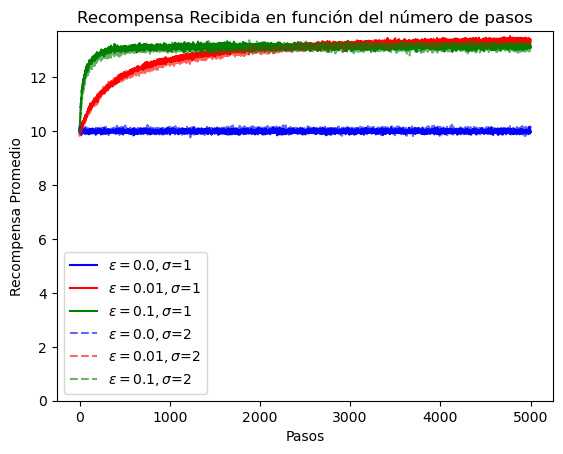

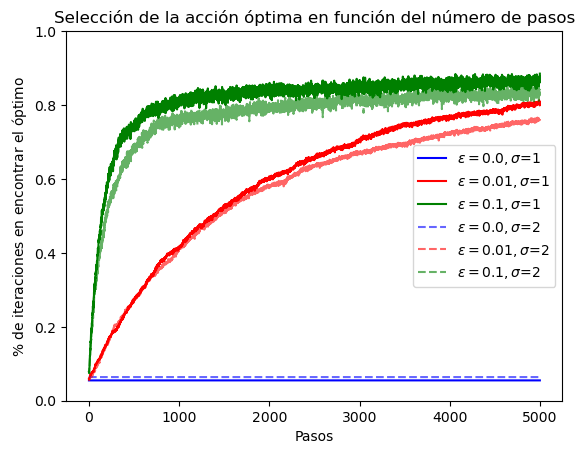

In [13]:
#Comparación para el caso Epsilon-Greedy
trans=0.6

plt.plot(avg_r0[:,0],c="b",label=f"$\epsilon=$"+str(epsilons[0])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(avg_r0[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(avg_r0[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(avg_r2a[:,0],c="b",label=f"$\epsilon=$"+str(epsilons[0])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(avg_r2a[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(avg_r2a[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.title("Recompensa Recibida en función del número de pasos")
plt.legend()
plt.show()


#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r0[:,0],c="b",label=f"$\epsilon=$"+str(epsilons[0])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(optimal_r0[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(optimal_r0[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(optimal_r2a[:,0],c="b",label=f"$\epsilon=$"+str(epsilons[0])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(optimal_r2a[:,1],c="r",label=f"$\epsilon=$"+str(epsilons[1])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(optimal_r2a[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.title("Selección de la acción óptima en función del número de pasos")
plt.ylim(0,1)
plt.legend()
plt.show()


Para poder evaluar el impacto de la modificación de la varianza de las acciones dentro de los modelos, en las Figuras mostradas en la parte superior, se puede observar una comparación del efecto en el algoritmo $\epsilon$-greedy. De acuerdo con los resultados se puede establecer que aunque las recompensas recibidas en promedio no cambian (vea la primera figura), el cambio principal se evidencia en la segunda figura, en dónde se observa que para todos los casos, cuando se tiene una menor varianza, se obtiene en promedio una mejor selección de la acción óptima. Esto se evidencia al comparar las gráficas para un mismo $\epsilon$ (tome por ejemplo el coplor verde) y comparar el desempeño (Curva de color más claro corresponde a una mayor varianza). De este análisis se muestra que para facilitar al algoritmo $\epsilon$-greedy un desempeño adecuado, la varianza de las acciones no debe tomarse muy alta, ay que tomar valores muy elevados, podría afectar la explotación del modelo, al hacer la exploración del algoritmo en un rango muy amplio de posibles recompensas.

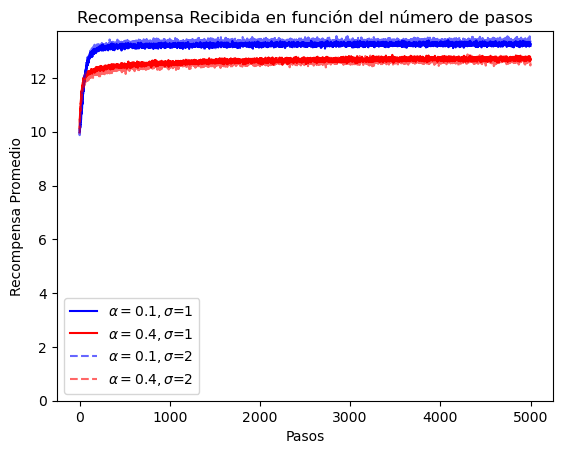

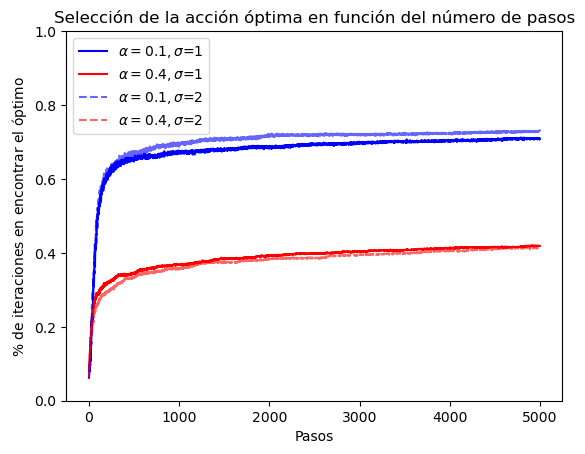

In [14]:
#Comparación para el caso Gradient Bandit
trans=0.6
plt.figure()

plt.plot(avg_r1[:,0],c="b",label=r"$\alpha=$"+str(alphas[0])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(avg_r1[:,1],c="r",label=r"$\alpha=$"+str(alphas[1])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
# plt.plot(avg_r1[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(avg_r2b[:,0],c="b",label=r"$\alpha=$"+str(alphas[0])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(avg_r2b[:,1],c="r",label=r"$\alpha=$"+str(alphas[1])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
# plt.plot(avg_r2b[:,2],c="g",label=f"$\epsilon=$"+str(epsilons[2])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.title("Recompensa Recibida en función del número de pasos")
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r1[:,0],c="b",label=r"$\alpha=$"+str(alphas[0])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(optimal_r1[:,1],c="r",label=r"$\alpha=$"+str(alphas[1])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
# plt.plot(optimal_r1[:,2],c="g",label=r"$\alpha=$"+str(alphas[2])+r"$, \sigma$="+str(int(np.sqrt(action_var))))
plt.plot(optimal_r2b[:,0],c="b",label=r"$\alpha=$"+str(alphas[0])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.plot(optimal_r2b[:,1],c="r",label=r"$\alpha=$"+str(alphas[1])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
# plt.plot(optimal_r2b[:,2],c="g",label=r"$\alpha=$"+str(alphas[2])+r"$, \sigma$="+str(int(np.sqrt(action_var1))),linestyle="dashed",alpha=trans)
plt.xticks(range(0,steps+1,1000))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.title("Selección de la acción óptima en función del número de pasos")
plt.ylim(0,1)
plt.legend()
plt.show()

Ahora bien, con respecto al algoritmo de Gradient Bandit, la modificación de la varianza de las acciones no tiene un impacto mayor en el potencial del modelo de identificar las acciones óptimas. De las gráficas de recompensas y porcentajes de obtención de las acciones óptimas no se puede evidenciar una diferencia tan notable como en el caso del algoritmo $\epsilon$-greedy. Aunque en el caso de $\alpha$ se ve una ligera mejora con una varianza un poco mayor, considerando la escala de los resultados, este efecto se considera de un menor grado dado que en ambos casos de varianza, el algoritmo de Gradient Bandit para $\alpha=0.1$ tiene una proporción de selección de la acción óptima cercana al 70%.

### 3. Cambio del Bandit cada $T$ iteraciones

Para la implementación del caso en el cual se modifica el multi-armed bandit cada $T$ iteraciones, de acuerdo con el enunciado del caso se implementará el algoritmo $\epsilon$-greedy con un tamaño de paso $\alpha$ constante. Para este caso, con respecto al punto 1 de esta implementación, se harán los siguientes cambios: 
-_cambios en cursiva_:


### *Initialize, for a=1 to k:*
$Q(a) \leftarrow 0$
$N(a) \leftarrow 0$


-_Hacer el loop para la cantidad de steps para hacer la explotación (primer caso) o la exploración (segundo caso)_



### *Loop for i in (steps):*

_Revisión si se lleva a una iteración múltiplo de T_

_(Se usa la función módulo para identificar cada cuánto se reinician los bandits)_

### si i % T:

$Q(a) \leftarrow N(q_*,\sigma_{action})$

_(Aquí se actualizan los bandits cada T periodos)_



$A \leftarrow argmax_a Q(a)$ with probability $1-\epsilon$

$A \leftarrow random action$ with probability $\epsilon$ 

_Recompensa_
$R \leftarrow bandit(A)$

$N(A) \leftarrow N(A)+1$

$Q(A) \leftarrow Q(A) + \alpha(R-Q(A))$

_(Aquí Q(A) ya no es incremental, sino que crece con una tasa $\alpha$ constante)_

En este caso, la función $Q(A)$ determina el aprendizaje como un proceso de aprendizaje incremental. A continuación la implementación del algoritmo $\epsilon$-greedy:

In [15]:
# Definición de función para entrenar a los bandits de acuerdo con la política epsilon-greedy no estacionaria
# input: epsilon (float), alpha -tamaño del paso (float) num_bandits (int), steps -u horizonte-(int), iter (int), T (int) -periodos en los que se reinicia el agente-
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima
def epsilon_greedy_mod (epsilon,alpha,num_bandits,steps,iter,T):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
            #arreglo para almacenar los valores de la recompensa esperada de cada acción tomada
        q_a=np.zeros(n_bandits)

            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)



            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):
                ######Cambio para que se reinicien los bandits cada T iteraciones
            if(s % T ==0):
                    #inicialización de valores q* para la iteración de evaluación        
                q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
                    #inicialziación del valor teórico máximo
                max_ini=arg_max(q_ini)

            act=0 #representa el bandit que se activa en la acción
            if np.random.rand()<epsilon:
                act=int(np.random.randint(num_bandits))
            else:
                act=int(arg_max(q_a))

                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var)
            
                #implementación incremental: permite el aprendizaje
                ######Cambio para que sla tasa de aprendizaje sea constante
            q_a[act]+=(reward_i-q_a[act])*alpha

                #alamcenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i
            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2

In [16]:
# Inicializaicón de los parámetros de los modelos
#     Número de los bandits (Acciones)
# n_bandits=10
#     #Media de las acciones q*
# mean_q=4
#     #Varianza de las acciones q*
# variance_q=1
#     #Varianza de cada acción (recompensa)
# action_var=1
#     #Número de pasos: horizonte
# steps=1000
#     #número de iteraciones (repeticiones del experimento)
# iter=100

#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0,0.01,0.1]
alpha=[0.1,0.4]
t=[80,500,steps]
#Función para evaluar múltiples valores para epsilon en la uimplementación de epsilon-greedy
def eval_eps_mod(epsilons,alpha, T):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r={}
    optimal_res={}
        #evalaución de las combinacioens de número de iteraciones y valor de epsilon para la evaluación
    for e in range(len(epsilons)):
        for a in range(len(alpha)):
            for i in range(len(T)):
                rewards,percent=epsilon_greedy_mod(epsilons[e],alpha[a],n_bandits,steps,iter,T[i])
                name="eps_"+str(epsilons[e])+"_alpha_"+str(alpha[a])+"_T_"+str(T[i])
                avg_r[name]=rewards
                optimal_res[name]=percent
    return avg_r,optimal_res


In [17]:
avg_r3,optimal_r3=eval_eps_mod(epsilons,alpha,t)

A continuación se mostrará una gráfica comparativa para los casos en los cuales T=80 (Azul), T=500 (Rojo) y solo a manera de referencia T=5000 (Verde) para comparar el efecto de esta modificación en el algoritmo $\epsilon$-greedy con $\alpha$ constante

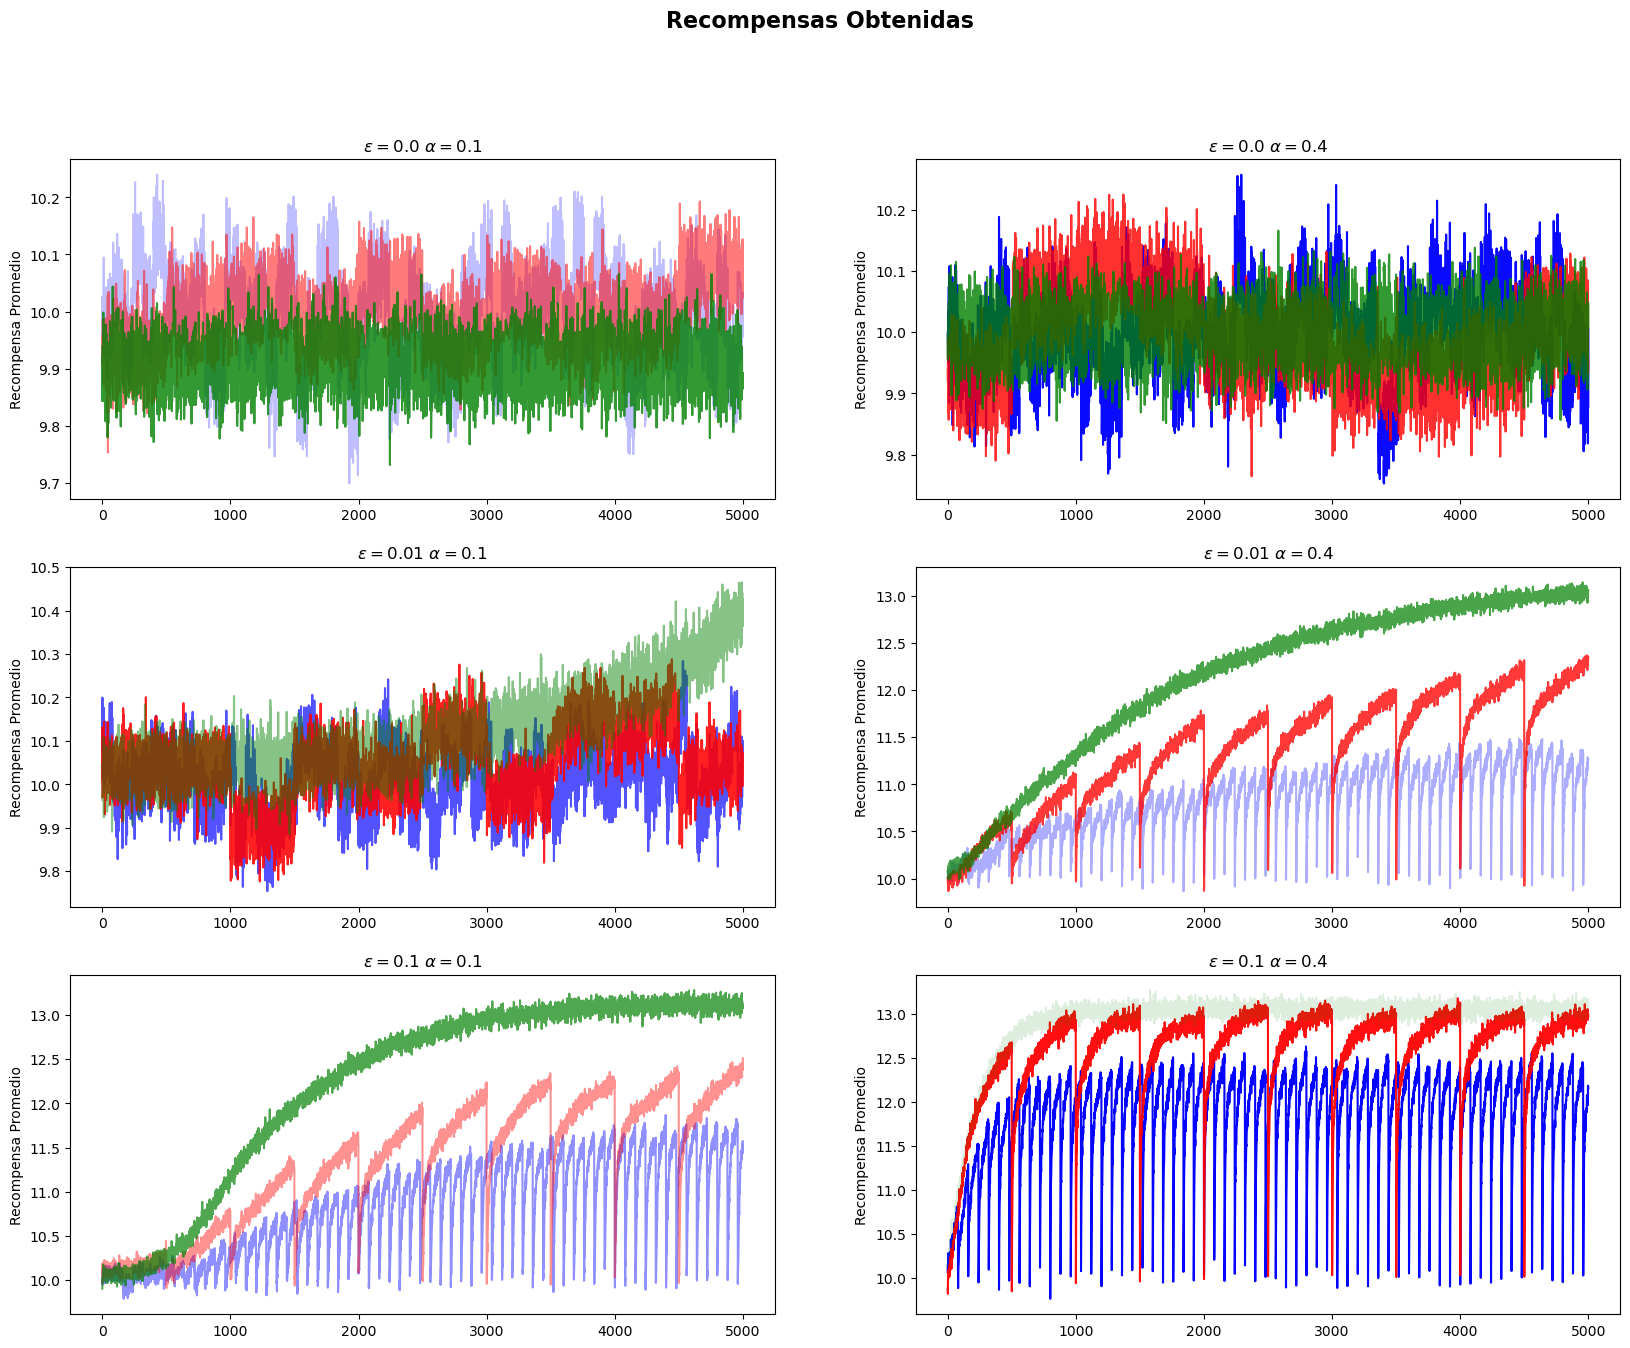

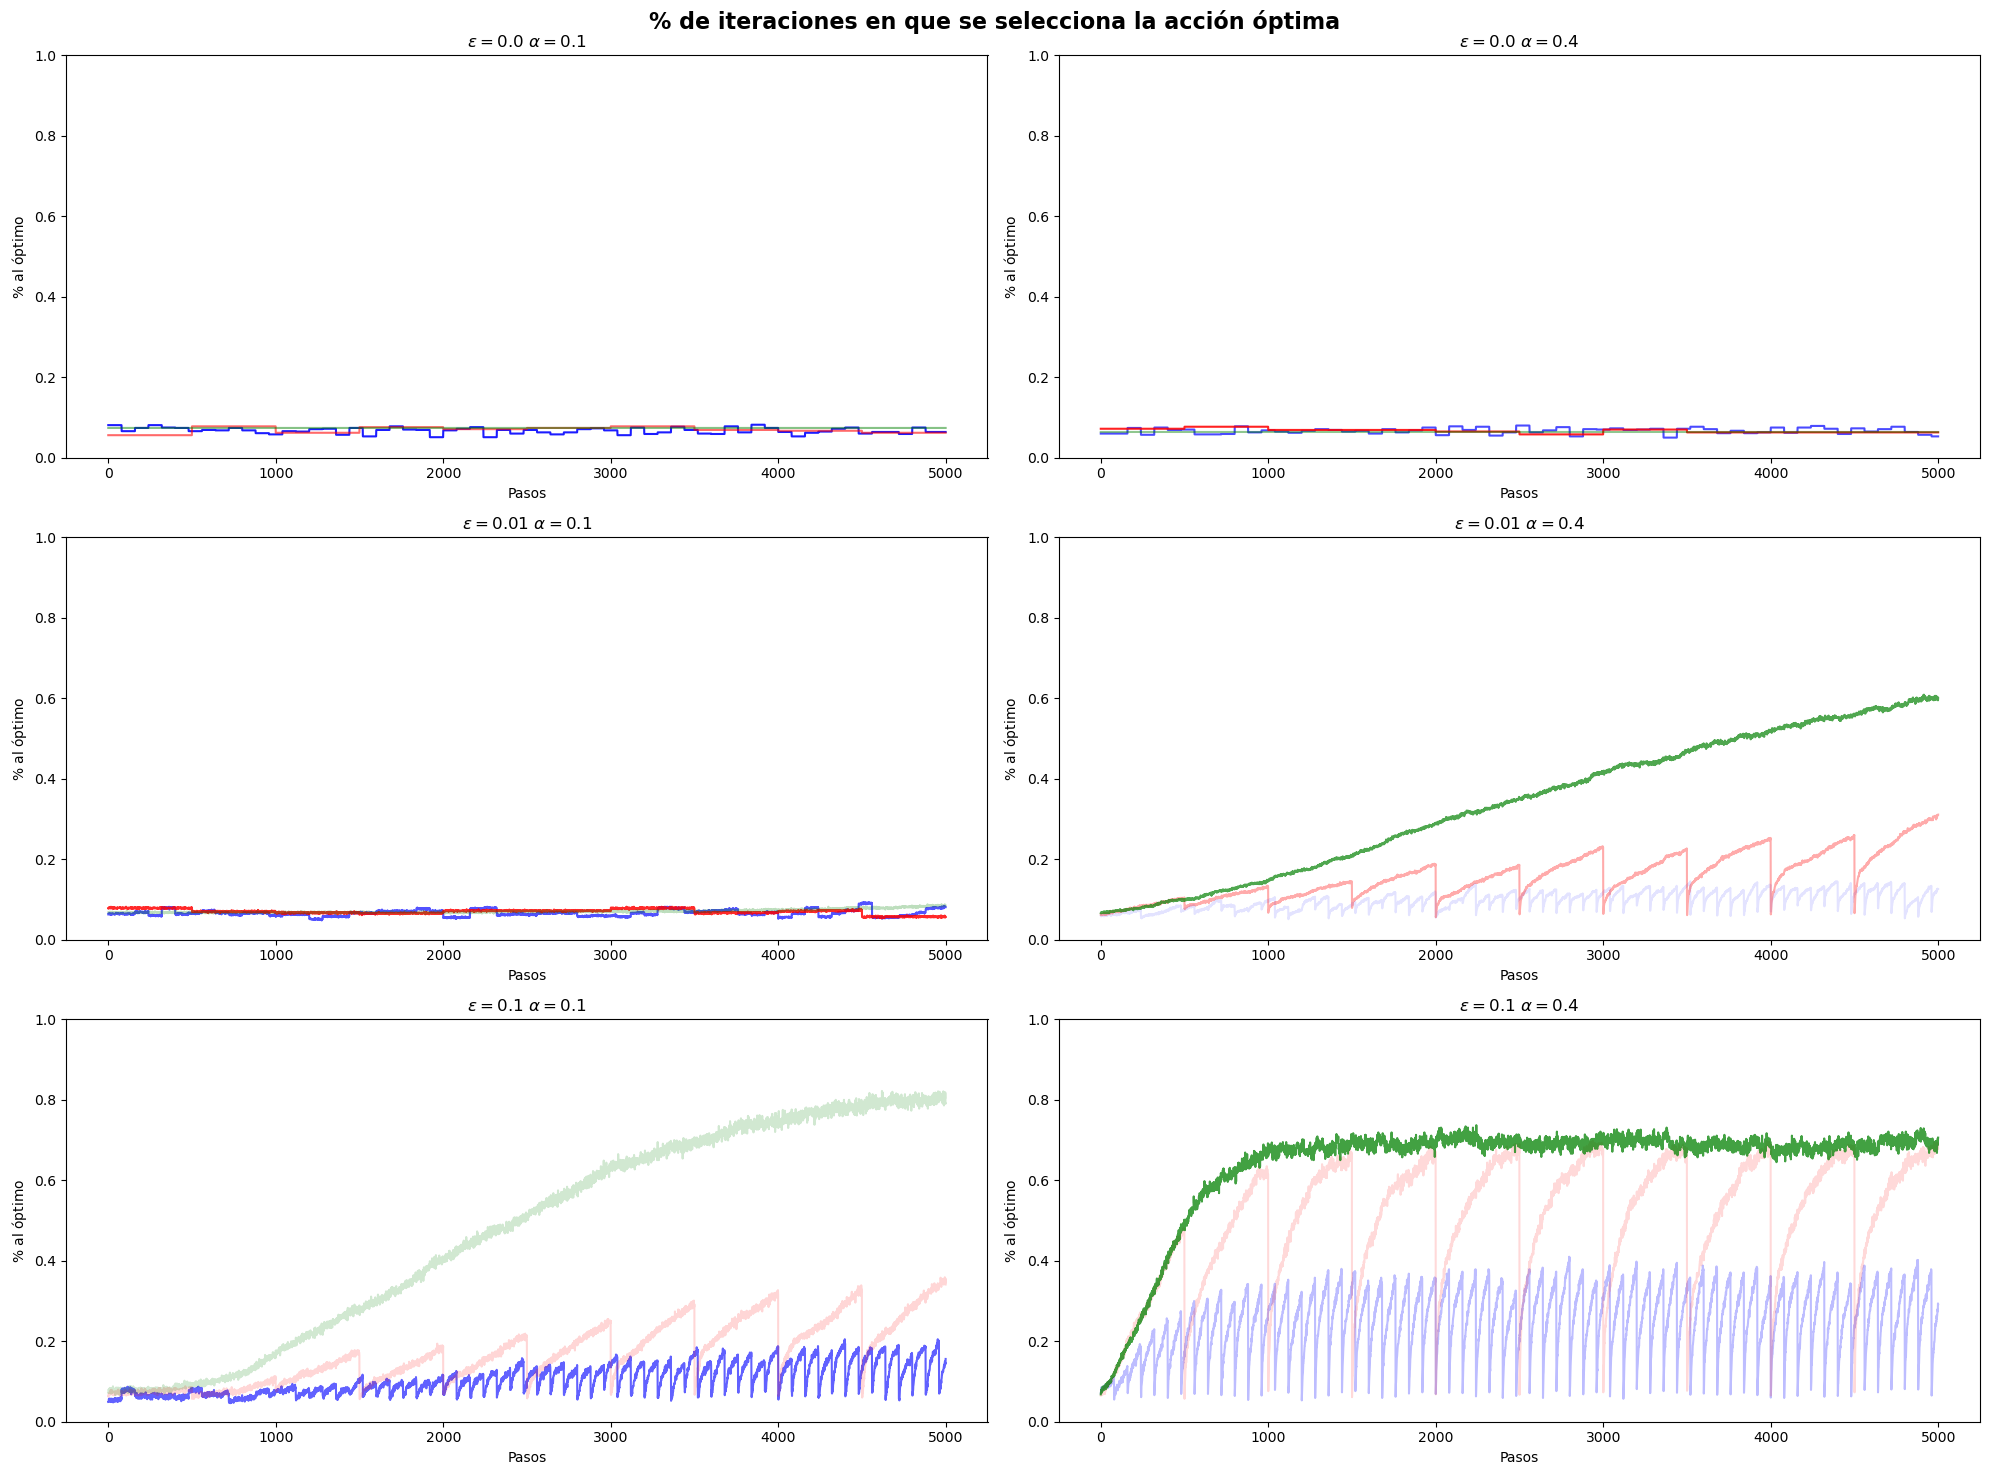

In [42]:
names=list(avg_r3.keys())
colors=["blue","red","green","orange","gray","black"]


fig1, axes1 = plt.subplots(len(epsilons),len(alphas), figsize=(20, 15))
fig2, axes2 = plt.subplots(len(epsilons),len(alphas), figsize=(20, 15))

for i in range(len(names)):
    #gráfica para la recompensa
    e=epsilons.index(float(names[i][names[i].find('_')+1:names[i].find('_',names[i].find('_')+1)]))
    j=alphas.index(float(names[i][names[i].find('_alpha_')+7:names[i].find('_T_',names[i].find('_alpha_')+7)]))

    if("T_"+str(t[0]) in names[i]):

        axes1[e,j].plot(avg_r3[names[i]],label=names[i],color="blue", alpha=np.random.randint(10,99)/100)
        axes1[e,j].set_xticks(range(0,steps+1,1000))
        axes1[e,j].set_ylabel("Recompensa Promedio")
        axes1[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))


        axes2[e,j].plot(optimal_r3[names[i]],label=names[i],color="blue", alpha=np.random.randint(10,99)/100)
        axes2[e,j].set_xlabel("Pasos")
        axes2[e,j].set_ylabel("$\%$ al óptimo")
        axes2[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))
        axes2[e,j].set_ylim(0,1)     
    elif("T_"+str(t[2]) in names[i]):
        axes1[e,j].plot(avg_r3[names[i]],label=names[i],color="green", alpha=np.random.randint(10,99)/100)
        axes1[e,j].set_xticks(range(0,steps+1,1000))
        axes1[e,j].set_ylabel("Recompensa Promedio")
        axes1[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))

        axes2[e,j].plot(optimal_r3[names[i]],label=names[i],color="green", alpha=np.random.randint(10,99)/100)
        axes2[e,j].set_xlabel("Pasos")
        axes2[e,j].set_ylabel("$\%$ al óptimo")
        axes2[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))
        axes2[e,j].set_ylim(0,1)                
    else:
        axes1[e,j].plot(avg_r3[names[i]],label=names[i],color="red", alpha=np.random.randint(10,99)/100)
        axes1[e,j].set_xticks(range(0,steps+1,1000))
        axes1[e,j].set_ylabel("Recompensa Promedio")
        axes1[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))
        
        axes2[e,j].plot(optimal_r3[names[i]],label=names[i],color="red", alpha=np.random.randint(10,99)/100)
        axes2[e,j].set_xlabel("Pasos")
        axes2[e,j].set_ylabel("$\%$ al óptimo")
        axes2[e,j].set_ylim(0,1)    
        axes2[e,j].set_title(r"$\epsilon=$"+str(epsilons[e])+r" $\alpha=$"+str(alphas[j]))

fig1.suptitle("Recompensas Obtenidas", fontsize=16, fontweight='bold')
plt.tight_layout()
fig2.suptitle("% de iteraciones en que se selecciona la acción óptima", fontsize=16, fontweight='bold')
plt.tight_layout()




Basado en la evaluación de los desempeños de los parámetros $\alpha$ y $\epsilon$ para los casos de cambio de los bandits cada $T$ periodos, se puede evidenciar que el efecto de este reinicio se observa como una caida a 0 en el % de acciones que llegan al óptimo cada T periodos, así como una drástica caída en la recompensa obtenida. Para los casos $T=80$ y $T=500$ se puede observar que los mejores parámetros del modelo serán:

$\epsilon=0.1$

$\alpha=0.4$

Estos valores son ideales incluso para el caso de $T=5000$ (o el caso que no hay reinicio de valores). Con respecto a la modificaicón de estos parámetros, para este caso en el que no hay un aprendizaje incremental, se evidencia una alta sensibilidad al requerimiento de asegurar una exploración (por ejemplo, valores muy bajos de epsilon causan recompensans difusas y proporciones de obtención del óptimo muy bajas).